In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
patients_df = pd.read_csv('data/adhd_data.csv')
patients_df[::] # Commented out to avoid printing sensitive data

In [ ]:
# Use PCA to reduce the dimensionality of the data and then plot the clusters

# Preprocess data to numbers
data_encoded = pd.get_dummies(patients_df, ["drug"])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_encoded)

def get_optimal_clusters(data, min_clusters=1, max_clusters=10):
    wcss = []
    for i in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=30, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.plot(range(min_clusters, max_clusters), wcss)
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.show()

# Split into clusters that have at least 10 items in them
get_optimal_clusters(df_scaled, 1, len(data_encoded) // 10)


In [ ]:
def run_kmeans(k, data):
    kmeans = KMeans(n_clusters=k, random_state=30, n_init=10)
    clusters = kmeans.fit_predict(data)

    df_pca = pca.fit_transform(data)

    # Convert to DataFrame
    df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = kmeans.labels_
    return (df_pca, clusters, k)

# Reduce to 2 principal components
pca = PCA(n_components=2)

# Run kmeans for 2-5 clusters
ks = [run_kmeans(i, df_scaled) for i in range(2,8)]

# Scatter plot of clusters
plt.figure(figsize=(15,10))

for i in range(len(ks)):
    k = ks[i]
    plt.subplot(3,3,i+1)
    sns.scatterplot(data=k[0], x="PC1", y="PC2", hue="Cluster", palette="viridis")
    plt.title(f"PCA - Cluster Visualization ({k[2]} Clusters)")
plt.show()

In [ ]:
# Selecting best performing cluster model (2 cluster model)
data_encoded['cluster'] = ks[0][1]

# Decode the encoded features
feature_columns = data_encoded.drop(columns="cluster").columns

pca_components = pd.DataFrame(
    pca.components_,
    columns=feature_columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
pc1_values = pca_components.T.sort_values(by="PC1", ascending=False).head(10)
pc2_values = pca_components.T.sort_values(by="PC2", ascending=False).head(10)

# Show features that contribute most to PC1 and PC2
# print(f"Top Features in PC1: {pc1_values} \n\nTop Features in PC2:{pc2_values}")
print(f"Top Features in PC1: \n{pc1_values}")

In [ ]:
print(f"Top Features in PC2:\n{pc2_values}")

In [ ]:
# decode drugs & plot them
drug_col = [col for col in data_encoded.columns if col.startswith("drug_")]
data_melted = pd.melt(data_encoded, id_vars="cluster",
                      value_vars=drug_col,
                      var_name="drug",
                      value_name="presence")
data_melted = data_melted[data_melted["presence"] == 1]
data_melted["drug"] = data_melted["drug"].str.replace("drug_", "")

plt.figure(figsize=(18,5))
sns.countplot(x="cluster", hue="drug", data=data_melted)
plt.title("Distribution of Medications per Cluster")

plt.legend(title="Drugs", bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=5)
plt.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
plt.figure(figsize=(10,15))
sns.heatmap(pca_components.T, annot=True, cmap="coolwarm")
plt.title("Feature Contributions to PCA Components")
plt.show()

In [82]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def run_model(data, epochs):
    # Prepare data
    df_tensor = torch.tensor(data, dtype=torch.float32)

    # Initialize and train the autoencoder
    model = Autoencoder(input_dim=df_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for i in range(epochs):
        optimizer.zero_grad()
        output = model(df_tensor)
        loss = criterion(output, df_tensor)
        loss.backward()
        optimizer.step()

    # Extract encoded features
    encoded_features = model.encoder(df_tensor).detach().numpy()

    # Cluster with K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    # TODO: Add this back if needed.
    #data_encoded['cluster_model'] = kmeans.fit_predict(encoded_features)

    return model, encoded_features, kmeans

In [83]:
model, enc_feats, kmeans = run_kmeans(25, df_scaled)

feature_names = data_encoded.columns  # Get the column names before scaling
print(f"Original Features: {len(feature_names)}, Latent Space Features: {enc_feats.shape[1]}")

# Extract the encoder weights
encoder_weights = model.encoder[0].weight.detach().numpy()

# Remove the 2 added features from the encoder ()
feature_names = feature_names[:79]

# Create a DataFrame to map feature contributions
latent_feature_importance = pd.DataFrame(encoder_weights, columns=feature_names)

# # Display the top contributing features for each latent variable
# for i in range(latent_dim):
#     print(f"\nTop Features for Latent Dimension {i}:")
#     print(latent_feature_importance.iloc[i].sort_values(ascending=False).head(10))
#

# Identify the most contributing features for each latent dimension
top_features = [latent_feature_importance.iloc[i].idxmax() for i in range(latent_dim)]

# Update the plot labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=enc_feats[:, 0], y=enc_feats[:, 1],
                hue=kmeans.labels_, palette="viridis", s=100, alpha=0.7)
plt.title("Latent Space Representation from Autoencoder")
plt.xlabel(f"Encoded Feature 1 ({top_features[0]})")
plt.ylabel(f"Encoded Feature 2 ({top_features[1]})")
plt.legend(title="Cluster")
plt.show()

IndexError: tuple index out of range

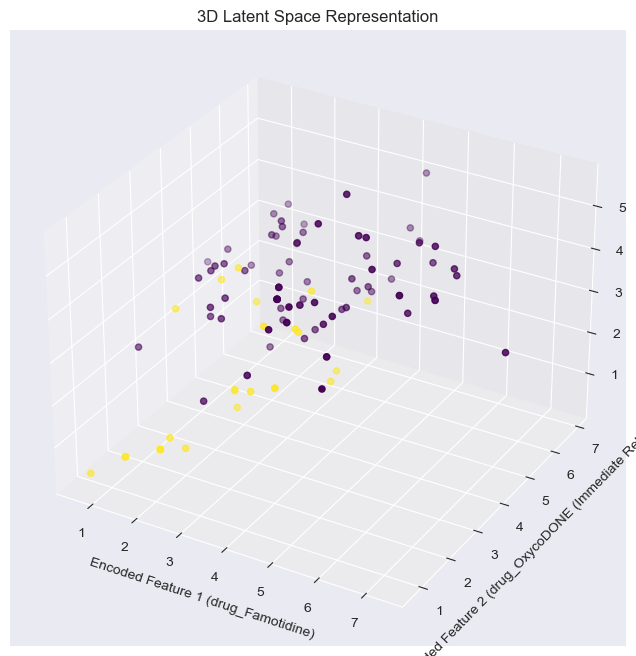

In [79]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_features[:, 0], encoded_features[:, 1], encoded_features[:, 2], c=kmeans.labels_, cmap="viridis")
ax.set_xlabel(f"Encoded Feature 1 ({top_features[0]})")
ax.set_ylabel(f"Encoded Feature 2 ({top_features[1]})")
ax.set_zlabel(f"Encoded Feature 3 ({top_features[2]})")
plt.title("3D Latent Space Representation")
plt.show()